In [1]:
import bisect
import json
import requests
import glob

import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from category_encoders.binary import BinaryEncoder
from IPython.display import clear_output

## Функция для чтения данных

In [2]:
def read_data(path,columns):
    data = pd.DataFrame()
    for name_column, column_type in columns.items():
        df_column = pd.DataFrame()
        for i in range(10):
            data_features_file = dd.read_parquet(
                path + f'\\part-0000{i}-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet')
            df_column = pd.concat([df_column, data_features_file[name_column].compute()], ignore_index=True)
        data[name_column] = df_column.astype(column_type)
    return data

## Популярный регион, всего регионов binary encoder

In [6]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'region_name': 'category'}
data = read_data(path,columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 2 columns):
 #   Column       Dtype   
---  ------       -----   
 0   user_id      int32   
 1   region_name  category
dtypes: category(1), int32(1)
memory usage: 1.5 GB


In [34]:
# в top_region количество строк с этим регионом у юзера
df = data.groupby(['user_id', 'region_name'])['region_name'].count()
df.name = 'top_region'

display(df.info())
print(df.index)

# удаляем из фрейма города, в которых не был человек
df = df[df != 0].reset_index()
display(df.head(20))
# в скольки регионах бывал пользователь
region_count = df.groupby('user_id', group_keys=False)['region_name'].count()
#оставляем только топовые регионы для каждого пользоватеоля
df = df.sort_values(by='top_region', ascending=False).drop_duplicates(subset='user_id', keep='first', ignore_index=True)
df = df.drop('top_region', axis=1)
#сортируем и добавляем колонку
df = df.sort_values(by='user_id').reset_index(drop=True)
df['region_count'] = region_count

<class 'pandas.core.series.Series'>
MultiIndex: 33640677 entries, (0, 'Алтайский край') to (415316, 'Ярославская область')
Series name: top_region
Non-Null Count     Dtype
--------------     -----
33640677 non-null  int64
dtypes: int64(1)
memory usage: 436.4 MB


None

MultiIndex([(     0,             'Алтайский край'),
            (     0,           'Амурская область'),
            (     0,      'Архангельская область'),
            (     0,       'Астраханская область'),
            (     0,       'Белгородская область'),
            (     0,           'Брянская область'),
            (     0,       'Владимирская область'),
            (     0,      'Волгоградская область'),
            (     0,        'Вологодская область'),
            (     0,        'Воронежская область'),
            ...
            (415316,      'Удмуртская Республика'),
            (415316,        'Ульяновская область'),
            (415316,           'Хабаровский край'),
            (415316, 'Ханты-Мансийский АО — Югра'),
            (415316,        'Челябинская область'),
            (415316,       'Чеченская Республика'),
            (415316,       'Чувашская Республика'),
            (415316,               'Чукотский АО'),
            (415316,          'Ямало-Ненецкий АО

,user_id,region_name,top_region
0,0,Москва,131
1,1,Москва,572
2,1,Московская область,37
3,1,Санкт-Петербург,91
4,2,Республика Коми,356
5,3,Воронежская область,188
6,4,Волгоградская область,23
7,4,Краснодарский край,459
8,4,Республика Башкортостан,97
9,4,Самарская область,11


In [35]:
display(df)
be = BinaryEncoder(cols=['region_name'],return_df=True)
df = be.fit_transform(df)
display(df)

,user_id,region_name,region_count
0,0,Москва,1
1,1,Москва,3
2,2,Республика Коми,1
3,3,Воронежская область,1
4,4,Краснодарский край,5
...,...,...,...
415312,415312,Тамбовская область,1
415313,415313,Саратовская область,1
415314,415314,Новосибирская область,1
415315,415315,Краснодарский край,1


,user_id,region_name_0,region_name_1,region_name_2,region_name_3,region_name_4,region_name_5,region_name_6,region_count
0,0,0,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,1,3
2,2,0,0,0,0,0,1,0,1
3,3,0,0,0,0,0,1,1,1
4,4,0,0,0,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...
415312,415312,1,0,0,0,1,1,0,1
415313,415313,0,0,1,1,0,0,0,1
415314,415314,0,0,1,0,0,1,1,1
415315,415315,0,0,0,0,1,0,0,1


In [36]:
display(df.info())
print(df['region_count'].max()) #int8
print(df['user_id'].max()) #int32

df[['region_count']] = df[['region_count']].astype('int8')
df[['user_id']] = df[['user_id']].astype('int32')
df[df.columns[~df.columns.isin(['region_count','user_id'])]] = df[df.columns[~df.columns.isin(['region_count','user_id'])]].astype('category')

display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   user_id        415317 non-null  int64
 1   region_name_0  415317 non-null  int64
 2   region_name_1  415317 non-null  int64
 3   region_name_2  415317 non-null  int64
 4   region_name_3  415317 non-null  int64
 5   region_name_4  415317 non-null  int64
 6   region_name_5  415317 non-null  int64
 7   region_name_6  415317 non-null  int64
 8   region_count   415317 non-null  int64
dtypes: int64(9)
memory usage: 28.5 MB


None

41
415316
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   user_id        415317 non-null  int32   
 1   region_name_0  415317 non-null  category
 2   region_name_1  415317 non-null  category
 3   region_name_2  415317 non-null  category
 4   region_name_3  415317 non-null  category
 5   region_name_4  415317 non-null  category
 6   region_name_5  415317 non-null  category
 7   region_name_6  415317 non-null  category
 8   region_count   415317 non-null  int8    
dtypes: category(7), int32(1), int8(1)
memory usage: 4.8 MB


None

In [38]:
df.to_parquet('..\\full_data\\figma_plan\\region.parquet', index=False)

## Популярный город, всего городов binary encoder

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'city_name': 'category'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 2 columns):
 #   Column     Dtype   
---  ------     -----   
 0   user_id    int32   
 1   city_name  category
dtypes: category(1), int32(1)
memory usage: 1.8 GB


In [6]:
df = data.groupby(['user_id', 'city_name'])['city_name'].count()
df.name = 'top_city'

display(df.info())
print(df.index)

df = df[df != 0].reset_index()
display(df.head(20))

city_count = df.groupby('user_id', group_keys=False)['city_name'].count()

df = df.sort_values(by='top_city', ascending=False).drop_duplicates(subset='user_id', keep='first', ignore_index=True)
df = df.drop('top_city', axis=1)

df = df.sort_values(by='user_id').reset_index(drop=True)
df['city_count'] = city_count

<class 'pandas.core.series.Series'>
MultiIndex: 409087245 entries, (0, 'Абаза') to (415316, 'Яхрома')
Series name: top_city
Non-Null Count      Dtype
--------------      -----
409087245 non-null  int64
dtypes: int64(1)
memory usage: 5.4 GB


None

MultiIndex([(     0,      'Абаза'),
            (     0,     'Абакан'),
            (     0,   'Абдулино'),
            (     0,     'Абинск'),
            (     0,    'Агидель'),
            (     0,      'Агрыз'),
            (     0,   'Адыгейск'),
            (     0,  'Азнакаево'),
            (     0,       'Азов'),
            (     0, 'Ак-Довурак'),
            ...
            (415316,     'Якутск'),
            (415316, 'Ялуторовск'),
            (415316,      'Янаул'),
            (415316,     'Яранск'),
            (415316,     'Яровое'),
            (415316,  'Ярославль'),
            (415316,     'Ярцево'),
            (415316,  'Ясногорск'),
            (415316,      'Ясный'),
            (415316,     'Яхрома')],
           names=['user_id', 'city_name'], length=409087245)


,user_id,city_name,top_city
0,0,Москва,131
1,1,Люберцы,6
2,1,Москва,572
3,1,Подольск,13
4,1,Санкт-Петербург,91
5,1,Химки,4
6,1,Чехов,14
7,2,Печора,356
8,3,Воронеж,188
9,4,Абинск,1


In [8]:
display(df)
be = BinaryEncoder(cols=['city_name'],return_df=True)
df = be.fit_transform(df)
display(df)

,user_id,city_name,city_count
0,0,Москва,1
1,1,Москва,6
2,2,Печора,1
3,3,Воронеж,1
4,4,Анапа,9
...,...,...,...
415312,415312,Моршанск,1
415313,415313,Саратов,1
415314,415314,Новосибирск,1
415315,415315,Краснодар,1


,user_id,city_name_0,city_name_1,city_name_2,city_name_3,city_name_4,city_name_5,city_name_6,city_name_7,city_name_8,city_name_9,city_count
0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,0,0,0,1,6
2,2,0,0,0,0,0,0,0,0,1,0,1
3,3,0,0,0,0,0,0,0,0,1,1,1
4,4,0,0,0,0,0,0,0,1,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
415312,415312,0,0,1,1,1,0,1,0,0,0,1
415313,415313,0,0,0,0,1,0,0,0,1,1,1
415314,415314,0,0,0,0,0,1,1,0,1,0,1
415315,415315,0,0,0,0,1,0,0,1,0,0,1


In [10]:
df = df.drop('user_id',axis=1)
display(df.info())
print(df['city_count'].max()) #int8

df[['city_count']] = df[['city_count']].astype('int8')
df[df.columns[~df.columns.isin(['city_count'])]] = df[df.columns[~df.columns.isin(['city_count'])]].astype('category')

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   city_name_0  415317 non-null  int64
 1   city_name_1  415317 non-null  int64
 2   city_name_2  415317 non-null  int64
 3   city_name_3  415317 non-null  int64
 4   city_name_4  415317 non-null  int64
 5   city_name_5  415317 non-null  int64
 6   city_name_6  415317 non-null  int64
 7   city_name_7  415317 non-null  int64
 8   city_name_8  415317 non-null  int64
 9   city_name_9  415317 non-null  int64
 10  city_count   415317 non-null  int64
dtypes: int64(11)
memory usage: 34.9 MB


None

124
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   city_name_0  415317 non-null  category
 1   city_name_1  415317 non-null  category
 2   city_name_2  415317 non-null  category
 3   city_name_3  415317 non-null  category
 4   city_name_4  415317 non-null  category
 5   city_name_5  415317 non-null  category
 6   city_name_6  415317 non-null  category
 7   city_name_7  415317 non-null  category
 8   city_name_8  415317 non-null  category
 9   city_name_9  415317 non-null  category
 10  city_count   415317 non-null  int8    
dtypes: category(10), int8(1)
memory usage: 4.4 MB


None

In [11]:
df.to_parquet('..\\full_data\\figma_plan\\city.parquet', index=False)
del df

## Производитель binary encoder

In [13]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'cpe_manufacturer_name': 'category'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())
display(len(data['cpe_manufacturer_name'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 2 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   user_id                int32   
 1   cpe_manufacturer_name  category
dtypes: category(1), int32(1)
memory usage: 1.5 GB


None

user_id                  0
cpe_manufacturer_name    0
dtype: int64

In [18]:
display(data.isna().sum())
df = data.groupby(['user_id', 'cpe_manufacturer_name'])['cpe_manufacturer_name'].count()
df.name = 'top_brend'

display(df.info())
print(df.index)

df = df[df != 0].reset_index()
display(df.head(20))

df = df.sort_values(by='top_brend', ascending=False).drop_duplicates(subset='user_id', keep='first', ignore_index=True)
df = df.drop('top_brend', axis=1)
df = df.sort_values(by='user_id').reset_index(drop=True)

user_id                  0
cpe_manufacturer_name    0
dtype: int64

<class 'pandas.core.series.Series'>
MultiIndex: 15366729 entries, (0, 'Alcatel') to (415316, 'ZTE')
Series name: top_brend
Non-Null Count     Dtype
--------------     -----
15366729 non-null  int64
dtypes: int64(1)
memory usage: 209.8 MB


None

MultiIndex([(     0,                           'Alcatel'),
            (     0,                             'Apple'),
            (     0,                              'Asus'),
            (     0,                         'Atlas LLC'),
            (     0,                'BQ Devices Limited'),
            (     0,                         'Blackview'),
            (     0,   'Doke Communication (HK) Limited'),
            (     0,                            'Doogee'),
            (     0,                        'Google Inc'),
            (     0,                               'HTC'),
            ...
            (415316,                           'Samsung'),
            (415316,                              'Sony'),
            (415316,   'Sony Mobile Communications Inc.'),
            (415316,                             'Tecno'),
            (415316, 'Umi Network Technology Co Limited'),
            (415316,      'Vingroup Joint Stock Company'),
            (415316,                    

,user_id,cpe_manufacturer_name,top_brend
0,0,Samsung,131
1,1,Xiaomi,700
2,2,Huawei,356
3,3,Huawei Device Company Limited,188
4,4,Huawei,591
5,5,Apple,2519
6,6,Huawei,456
7,7,Huawei,461
8,8,Apple,976
9,9,Apple,315


In [22]:
display(df)
be = BinaryEncoder(cols=['cpe_manufacturer_name'],return_df=True)
df = be.fit_transform(df)
display(df)

,user_id,cpe_manufacturer_name
0,0,Samsung
1,1,Xiaomi
2,2,Huawei
3,3,Huawei Device Company Limited
4,4,Huawei
...,...,...
415312,415312,Huawei
415313,415313,Xiaomi
415314,415314,Huawei Device Company Limited
415315,415315,Huawei


,user_id,cpe_manufacturer_name_0,cpe_manufacturer_name_1,cpe_manufacturer_name_2,cpe_manufacturer_name_3,cpe_manufacturer_name_4,cpe_manufacturer_name_5
0,0,0,0,0,0,0,1
1,1,0,0,0,0,1,0
2,2,0,0,0,0,1,1
3,3,0,0,0,1,0,0
4,4,0,0,0,0,1,1
...,...,...,...,...,...,...,...
415312,415312,0,0,0,0,1,1
415313,415313,0,0,0,0,1,0
415314,415314,0,0,0,1,0,0
415315,415315,0,0,0,0,1,1


In [23]:
df = df.drop('user_id',axis=1)
display(df.info())

df[df.columns] = df[df.columns].astype('category')

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   cpe_manufacturer_name_0  415317 non-null  int64
 1   cpe_manufacturer_name_1  415317 non-null  int64
 2   cpe_manufacturer_name_2  415317 non-null  int64
 3   cpe_manufacturer_name_3  415317 non-null  int64
 4   cpe_manufacturer_name_4  415317 non-null  int64
 5   cpe_manufacturer_name_5  415317 non-null  int64
dtypes: int64(6)
memory usage: 19.0 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   cpe_manufacturer_name_0  415317 non-null  category
 1   cpe_manufacturer_name_1  415317 non-null  category
 2   cpe_manufacturer_name_2  415317 non-null  category
 3   cpe_manufacturer_name_3  415317 non-null  category
 4   cpe_manufacturer_name_4  415317 non-null  category
 5   cpe_manufacturer_name_5  415317 non-null  category
dtypes: category(6)
memory usage: 2.4 MB


None

In [24]:
df.to_parquet('..\\full_data\\figma_plan\\cpe_manufacturer.parquet', index=False)
del df

## Количество моделей

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'cpe_model_name': 'category'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())
display(len(data['cpe_model_name'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 2 columns):
 #   Column          Dtype   
---  ------          -----   
 0   user_id         int32   
 1   cpe_model_name  category
dtypes: category(1), int32(1)
memory usage: 1.8 GB


None

user_id           0
cpe_model_name    0
dtype: int64

599

In [12]:
df = data.groupby(['user_id', 'cpe_model_name'])['cpe_model_name'].count()
df.name = 'top_model'

display(df.info())
print(df.index)

df = df[df != 0].reset_index()
display(df.head(20))

model_count = df.groupby('user_id', group_keys=False)['cpe_model_name'].count()
df['model_count'] = model_count

<class 'pandas.core.series.Series'>
MultiIndex: 248774883 entries, (0, '1') to (415316, 'iPhone Xs Max')
Series name: top_model
Non-Null Count      Dtype
--------------      -----
248774883 non-null  int64
dtypes: int64(1)
memory usage: 3.3 GB


None

MultiIndex([(     0,              '1'),
            (     0,         '1 Dual'),
            (     0,  '11 Lite 5G NE'),
            (     0,            '11T'),
            (     0,        '15 Lite'),
            (     0,             '16'),
            (     0,           '16th'),
            (     0,           '1904'),
            (     0,             '1S'),
            (     0,             '1X'),
            ...
            (415316,       'iPhone 7'),
            (415316,  'iPhone 7 Plus'),
            (415316,       'iPhone 8'),
            (415316,  'iPhone 8 Plus'),
            (415316,      'iPhone SE'),
            (415316, 'iPhone SE 2020'),
            (415316,       'iPhone X'),
            (415316,      'iPhone XR'),
            (415316,      'iPhone Xs'),
            (415316,  'iPhone Xs Max')],
           names=['user_id', 'cpe_model_name'], length=248774883)


,user_id,cpe_model_name,top_model
0,0,Galaxy J1 2016 LTE Dual,131
1,1,Mi 9,700
2,2,Honor 9 Lite,356
3,3,P Smart 2021,188
4,4,Nova 3,591
5,5,iPhone 8 Plus,2519
6,6,Honor 8A,456
7,7,P20 Lite,461
8,8,iPhone XR,976
9,9,iPhone XR,315


In [14]:
df['model_count'].value_counts()

1    415317
Name: model_count, dtype: int64

#### У всех пользователей оказалось по одной модели, поэтому столбец неинформативен

## Тип устройства binary encoder

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'cpe_type_cd': 'category'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())
display(len(data['cpe_type_cd'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 2 columns):
 #   Column       Dtype   
---  ------       -----   
 0   user_id      int32   
 1   cpe_type_cd  category
dtypes: category(1), int32(1)
memory usage: 1.5 GB


None

user_id        0
cpe_type_cd    0
dtype: int64

4

In [7]:
df = data.drop_duplicates(subset='user_id',ignore_index=True)

display(df)
be = BinaryEncoder(cols=['cpe_type_cd'],return_df=True)
df = be.fit_transform(df)
df = df.sort_values(by='user_id').reset_index(drop=True)
display(df)

,user_id,cpe_type_cd
0,45098,smartphone
1,117132,smartphone
2,79395,smartphone
3,91294,smartphone
4,161323,smartphone
...,...,...
415312,375972,smartphone
415313,160996,smartphone
415314,5505,smartphone
415315,260127,smartphone


,user_id,cpe_type_cd_0,cpe_type_cd_1,cpe_type_cd_2
0,0,0,0,1
1,1,0,0,1
2,2,0,0,1
3,3,0,0,1
4,4,0,0,1
...,...,...,...,...
415312,415312,0,0,1
415313,415313,0,0,1
415314,415314,0,0,1
415315,415315,0,0,1


In [8]:
df = df.drop('user_id',axis=1)
display(df.info())

df[df.columns] = df[df.columns].astype('category')

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   cpe_type_cd_0  415317 non-null  int64
 1   cpe_type_cd_1  415317 non-null  int64
 2   cpe_type_cd_2  415317 non-null  int64
dtypes: int64(3)
memory usage: 9.5 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   cpe_type_cd_0  415317 non-null  category
 1   cpe_type_cd_1  415317 non-null  category
 2   cpe_type_cd_2  415317 non-null  category
dtypes: category(3)
memory usage: 1.2 MB


None

In [21]:
df.to_parquet('..\\full_data\\figma_plan\\cpe_type.parquet', index=False)
del df

## Цена устройства, создание категорий

In [9]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'price': 'float32'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int32  
 1   price    float32
dtypes: float32(1), int32(1)
memory usage: 2.4 GB


None

user_id          0
price      6589482
dtype: int64

In [10]:
df = data.drop_duplicates(subset='user_id',ignore_index=True)
df = df.sort_values(by='user_id').reset_index(drop=True)
display(df)
display(df.isna().sum())

,user_id,price
0,0,2990.0
1,1,NaN
2,2,5915.0
3,3,13990.0
4,4,12990.0
...,...,...
415312,415312,7947.0
415313,415313,4790.0
415314,415314,16990.0
415315,415315,6990.0


user_id        0
price      10754
dtype: int64

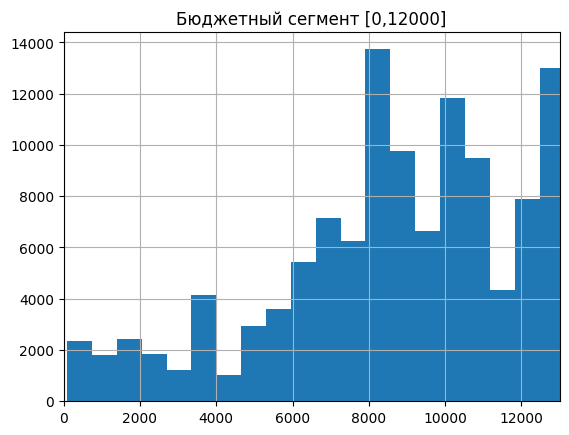

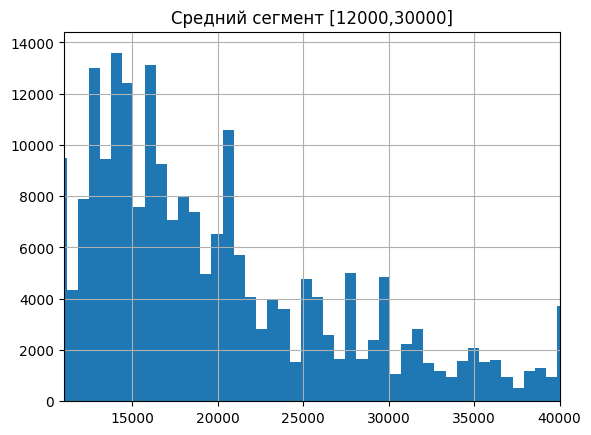

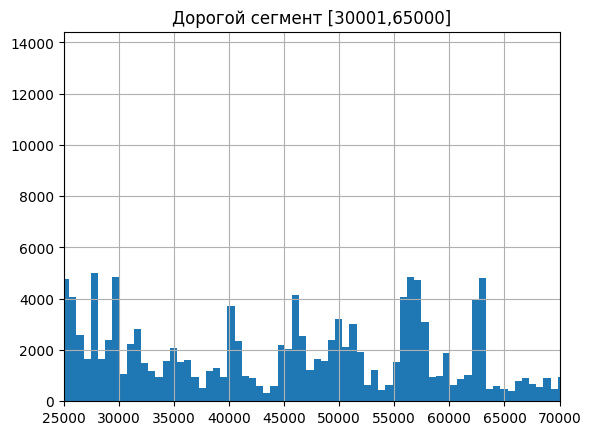

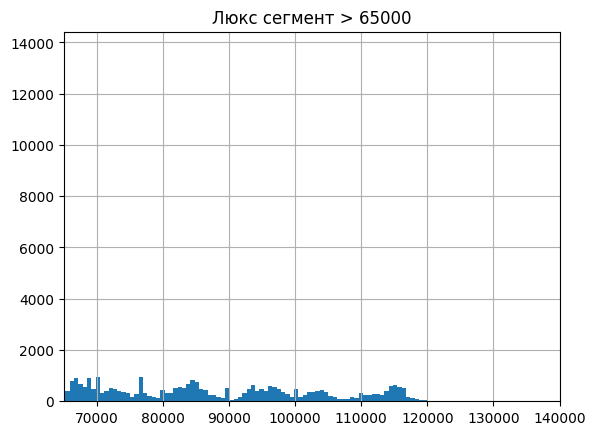

In [11]:
plt.xlim(0,13000)
plt.title('Бюджетный сегмент [0,12000]')
df['price'].hist(bins=300)
plt.show()

plt.xlim(11000,40000)
plt.title('Средний сегмент [12000,30000]')
df['price'].hist(bins=300)
plt.show()

plt.xlim(25000,70000)
plt.title('Дорогой сегмент [30001,65000]')
df['price'].hist(bins=300)
plt.show()

plt.xlim(65000,140000)
plt.title('Люкс сегмент > 65000')
df['price'].hist(bins=300)
plt.show()

In [12]:
df = df.fillna(-10)
display(df.isna().sum())

display(df)
df['price'] = df['price'].apply(lambda price: bisect.bisect_left([-1,12000,30000,65000],price))
df = df.drop('user_id',axis=1)
display(df)

user_id    0
price      0
dtype: int64

,user_id,price
0,0,2990.0
1,1,-10.0
2,2,5915.0
3,3,13990.0
4,4,12990.0
...,...,...
415312,415312,7947.0
415313,415313,4790.0
415314,415314,16990.0
415315,415315,6990.0


,price
0,1
1,0
2,1
3,2
4,2
...,...
415312,1
415313,1
415314,2
415315,1


array([[<AxesSubplot: title={'center': 'price'}>]], dtype=object)

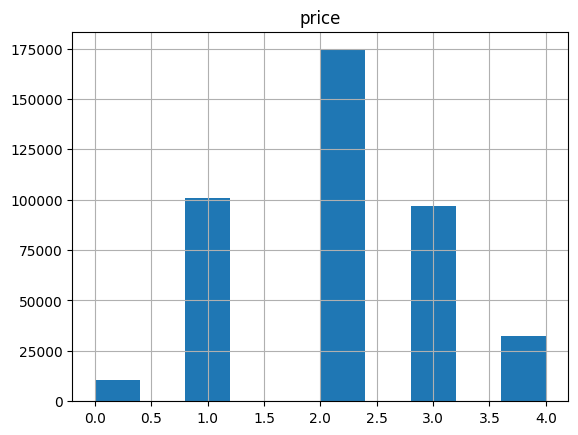

In [13]:
df.hist()

In [128]:
df.to_parquet('..\\full_data\\figma_plan\\price.parquet', index=False)
del df

## Доли запросов в выходной

In [35]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'request_cnt': 'int8','date': 'datetime64[ns]'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int32         
 1   request_cnt  int8          
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int8(1)
memory usage: 3.9 GB


None

user_id        0
request_cnt    0
date           0
dtype: int64

In [36]:
url21 = 'https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/consultant' + '2021' + '.json'
r21 = requests.get(url21)
cal21 = json.loads(r21.text)

url22 = 'https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/consultant' + '2022' + '.json'
r22 = requests.get(url22)
cal22 = json.loads(r22.text)

def is_holiday(date):
    if date.year == 2021:
        return cal21['holidays'].count(str(date)[0:-9])
    else:
        return cal22['holidays'].count(str(date)[0:-9])

data['date'] = data['date'].apply(lambda date: is_holiday(date))
data.head()

,user_id,request_cnt,date
0,45098,1,0
1,45098,1,1
2,45098,1,1
3,45098,1,0
4,45098,1,0


In [38]:
data['date'] = data['date'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype   
---  ------       -----   
 0   user_id      int32   
 1   request_cnt  int8    
 2   date         category
dtypes: category(1), int32(1), int8(1)
memory usage: 1.8 GB


In [71]:
df = data.groupby(['user_id','date'],group_keys=False)['request_cnt'].sum().reset_index()
display(df.head())
df['request_cnt_sum'] = pd.Series(np.repeat(df.groupby('user_id')['request_cnt'].sum().reset_index(drop=True).values,2,axis=0))
display(df.head())
df['holyday_fraction'] = df['request_cnt']/df['request_cnt_sum']
df['holyday_fraction'] = df['holyday_fraction'].astype('float32')
display(df.head())

df = df.loc[df['date']==1].drop(['request_cnt_sum','request_cnt','date'],axis=1).reset_index(drop=True)
display(df.head())
df = df.drop('user_id',axis=1)
display(df.info())

,user_id,date,request_cnt
0,0,0,146
1,0,1,47
2,1,0,837
3,1,1,210
4,2,0,288


,user_id,date,request_cnt,request_cnt_sum
0,0,0,146,193
1,0,1,47,193
2,1,0,837,1047
3,1,1,210,1047
4,2,0,288,411


,user_id,date,request_cnt,request_cnt_sum,holyday_fraction
0,0,0,146,193,0.756477
1,0,1,47,193,0.243523
2,1,0,837,1047,0.799427
3,1,1,210,1047,0.200573
4,2,0,288,411,0.700730


,user_id,holyday_fraction
0,0,0.243523
1,1,0.200573
2,2,0.299270
3,3,0.181818
4,4,0.326898


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   holyday_fraction  415317 non-null  float32
dtypes: float32(1)
memory usage: 1.6 MB


None

In [72]:
df.to_parquet('..\\full_data\\figma_plan\\holyday_fraction.parquet', index=False)
del df

## Доли запросов утро, день, вечер

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32', 'request_cnt': 'int8','part_of_day': 'category'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype   
---  ------       -----   
 0   user_id      int32   
 1   request_cnt  int8    
 2   part_of_day  category
dtypes: category(1), int32(1), int8(1)
memory usage: 1.8 GB


None

user_id        0
request_cnt    0
part_of_day    0
dtype: int64

In [26]:
df = data.groupby(['user_id','part_of_day'],group_keys=False)['request_cnt'].sum().reset_index()
display(df.head())
df['request_cnt_sum'] = pd.Series(np.repeat(df.groupby('user_id')['request_cnt'].sum().reset_index(drop=True).values,4,axis=0))
display(df.head())

frac_df = pd.DataFrame()
frac_df['user_id'] = df['user_id'].drop_duplicates().reset_index(drop=True)
frac_df['morning_fraction'] = (df.loc[df['part_of_day']=='morning','request_cnt'] / df.loc[df['part_of_day']=='morning','request_cnt_sum']).reset_index(drop=True)
frac_df['morning_fraction'] = frac_df['morning_fraction'].astype('float32')
frac_df['day_fraction'] = (df.loc[df['part_of_day']=='day','request_cnt'] / df.loc[df['part_of_day']=='day','request_cnt_sum']).reset_index(drop=True)
frac_df['day_fraction'] = frac_df['day_fraction'].astype('float32')
frac_df['evening_fraction'] = (df.loc[df['part_of_day']=='evening','request_cnt'] / df.loc[df['part_of_day']=='evening','request_cnt_sum']).reset_index(drop=True)
frac_df['evening_fraction'] = frac_df['evening_fraction'].astype('float32')
display(frac_df.head())

frac_df = frac_df.round(3).drop('user_id',axis=1)
display(frac_df.head())
display(frac_df.info())

,user_id,part_of_day,request_cnt
0,0,day,107
1,0,evening,62
2,0,morning,23
3,0,night,1
4,1,day,363


,user_id,part_of_day,request_cnt,request_cnt_sum
0,0,day,107,193
1,0,evening,62,193
2,0,morning,23,193
3,0,night,1,193
4,1,day,363,1047


,user_id,morning_fraction,day_fraction,evening_fraction
0,0,0.119171,0.554404,0.321244
1,1,0.322827,0.346705,0.295129
2,2,0.187348,0.481752,0.316302
3,3,0.178182,0.352727,0.454545
4,4,0.371943,0.348777,0.265122


,morning_fraction,day_fraction,evening_fraction
0,0.119,0.554,0.321
1,0.323,0.347,0.295
2,0.187,0.482,0.316
3,0.178,0.353,0.455
4,0.372,0.349,0.265


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   morning_fraction  415317 non-null  float32
 1   day_fraction      415317 non-null  float32
 2   evening_fraction  415317 non-null  float32
dtypes: float32(3)
memory usage: 4.8 MB


None

In [27]:
frac_df.to_parquet('..\\full_data\\figma_plan\\part_of_day_fraction.parquet', index=False)
del df
del frac_df

## Топ доли заходов на 3000 популярных сайтов + доля заходов на остальные

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32','request_cnt': 'int8','url_host': 'object'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 3.9+ GB


None

user_id        0
request_cnt    0
url_host       0
dtype: int64

In [4]:
'''


сохраняем список сайтов, в которых приемлемое количество запросов
сохраняем список сайтов, которые наверняка будут добавлены в df


'''

important_df = data.groupby('url_host')['request_cnt'].sum().reset_index().sort_values(by='request_cnt',ascending=False)
display(important_df.head())
print(len(important_df))
display(important_df.describe().round(2))

important_df = important_df.loc[important_df['request_cnt']>50]
display(important_df.head())
print(len(important_df))
display(important_df.describe().round(2))

important_columns = important_df['url_host'].unique()
del important_df

np.save('important_columns.npy', important_columns, allow_pickle=True)
important_columns = np.load('important_columns.npy',allow_pickle=True)

np.save('exists_columns.npy', important_columns[0:3000], allow_pickle=True)
exists_columns = np.load('exists_columns.npy',allow_pickle=True)
print(important_columns)
print(len(exists_columns))

,url_host,request_cnt
59366,googleads.g.doubleclick.net,49094546
194523,yandex.ru,47494474
65865,i.ytimg.com,35166640
180836,vk.com,34750259
17626,avatars.mds.yandex.net,29760534


199683


,request_cnt
count,199683.00
mean,2788.13
std,242249.42
min,1.00
25%,1.00
50%,4.00
75%,14.00
max,49094546.00


,url_host,request_cnt
59366,googleads.g.doubleclick.net,49094546
194523,yandex.ru,47494474
65865,i.ytimg.com,35166640
180836,vk.com,34750259
17626,avatars.mds.yandex.net,29760534


24017


,request_cnt
count,24017.00
mean,23130.71
std,698188.05
min,51.00
25%,82.00
50%,155.00
75%,434.00
max,49094546.00


['googleads.g.doubleclick.net' 'yandex.ru' 'i.ytimg.com' ...
 'buildingclub-ru.turbopages.org' 'insearch.site' 'el-id.ru']
3000


In [4]:
#сохраняем данные о сумме перед удалением или переименовыванием строк
data_sum = data.groupby('user_id')['request_cnt'].sum().reset_index()
data_sum['user_id'] = data_sum['user_id'].astype('int32')
data_sum['request_cnt'] = data_sum['request_cnt'].astype('int32')
data_sum = data_sum.rename(columns={'request_cnt':'request_cnt_sum'})
display(data_sum.head())
display(data_sum.info())

,user_id,request_cnt_sum
0,0,193
1,1,1047
2,2,411
3,3,275
4,4,777


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   user_id          415317 non-null  int32
 1   request_cnt_sum  415317 non-null  int32
dtypes: int32(2)
memory usage: 3.2 MB


None

In [5]:
#оставляем топ 3000, остальные переименуем в 'other_url'
exists_columns = np.load('exists_columns.npy',allow_pickle=True)
data.loc[~data['url_host'].isin(exists_columns),'url_host'] = 'other_url'
exists_columns = np.append(exists_columns,'other_url')
display(data.head())
display(data.info())

,user_id,request_cnt,url_host
0,45098,1,ad.adriver.ru
1,45098,1,apple.com
2,45098,1,avatars.mds.yandex.net
3,45098,1,googleads.g.doubleclick.net
4,45098,1,googleads.g.doubleclick.net


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 3.9+ GB


None

In [6]:
df = data.groupby(['user_id','url_host'],group_keys=False)['request_cnt'].sum().reset_index()
del data
df = df.merge(data_sum[['request_cnt_sum','user_id']], on = 'user_id', how = 'inner')
del data_sum
df = df.set_index('user_id')
df['fraction'] = df['request_cnt']/df['request_cnt_sum']
df = df.drop(['request_cnt','request_cnt_sum'],axis=1)
display(df.head())
display(df.info())

,url_host,fraction
user_id,,
0,ad.adriver.ru,0.005181
0,ad.mail.ru,0.031088
0,ads.adfox.ru,0.025907
0,ads.betweendigital.com,0.010363
0,avatars.mds.yandex.net,0.046632


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28995021 entries, 0 to 415316
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   url_host  object 
 1   fraction  float64
dtypes: float64(1), object(1)
memory usage: 663.6+ MB


None

In [7]:
%%time
frac_df = pd.DataFrame()
frac_df['user_id'] = df.index.drop_duplicates()
frac_df = pd.concat([frac_df,pd.DataFrame(0,index=df.index.drop_duplicates(),columns=exists_columns)],axis=1)

prog_bar=1
for column in exists_columns:
    clear_output(wait=True)
    frac_df.loc[:,column] = df.loc[df['url_host'] == column,'fraction']
    frac_df[column] = frac_df[column].astype('float32')
    print(round(prog_bar/len(exists_columns)*100,1),'%')
    prog_bar += 1

display(frac_df.head())
display(frac_df.info())

100.0 %


,user_id,googleads.g.doubleclick.net,yandex.ru,i.ytimg.com,vk.com,avatars.mds.yandex.net,ad.mail.ru,yastatic.net,apple.com,instagram.com,...,psy-magic.org,megapteka-ru.turbopages.org,127.0.0.1,bukvaprava.ru,belnovosti-by.turbopages.org,ngs24-ru.turbopages.org,forum.mfd.ru,yomed.ru,7info.ru,other_url
0,0,0.196891,0.031088,0.025907,0.041451,0.046632,0.031088,0.051813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031088
1,1,0.072588,0.112703,0.040115,0.023878,0.104107,0.034384,0.081184,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013372
2,2,0.092457,0.046229,0.126521,0.141119,0.072993,0.038929,0.046229,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002433
3,3,0.021818,0.061818,0.007273,0.178182,0.094545,0.080000,0.069091,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010909
4,4,0.061776,0.030888,0.048906,0.083655,0.046332,0.061776,0.045045,NaN,0.003861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011583


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Columns: 3002 entries, user_id to other_url
dtypes: float32(3001), int64(1)
memory usage: 4.6 GB


None

CPU times: total: 1h 32min 56s
Wall time: 1h 39min 34s


In [10]:
frac_df = frac_df.fillna(0)
frac_df.head(50)

,user_id,googleads.g.doubleclick.net,yandex.ru,i.ytimg.com,vk.com,avatars.mds.yandex.net,ad.mail.ru,yastatic.net,apple.com,instagram.com,...,psy-magic.org,megapteka-ru.turbopages.org,127.0.0.1,bukvaprava.ru,belnovosti-by.turbopages.org,ngs24-ru.turbopages.org,forum.mfd.ru,yomed.ru,7info.ru,other_url
0,0,0.196891,0.031088,0.025907,0.041451,0.046632,0.031088,0.051813,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.031088
1,1,0.072588,0.112703,0.040115,0.023878,0.104107,0.034384,0.081184,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.013372
2,2,0.092457,0.046229,0.126521,0.141119,0.072993,0.038929,0.046229,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.002433
3,3,0.021818,0.061818,0.007273,0.178182,0.094545,0.080000,0.069091,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010909
4,4,0.061776,0.030888,0.048906,0.083655,0.046332,0.061776,0.045045,0.000000,0.003861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.011583
5,5,0.046949,0.044001,0.025176,0.036743,0.059651,0.017691,0.053073,0.117714,0.100249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.009299
6,6,0.042892,0.066176,0.047794,0.148284,0.030637,0.120098,0.026961,0.000000,0.001225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.014706
7,7,0.115747,0.220727,0.078062,0.113055,0.061911,0.001346,0.082100,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
8,8,0.083700,0.027313,0.057269,0.080176,0.051101,0.041410,0.021145,0.096916,0.008811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010573
9,9,0.134409,0.003584,0.003584,0.082437,0.032258,0.096774,0.016129,0.093190,0.112903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.001792


In [12]:
del df
frac_df = frac_df.drop('user_id',axis=1)
display(frac_df.head())
display(frac_df.info())

frac_df.to_parquet('..\\full_data\\figma_plan\\top_3000_urls_fraction.parquet', index=False)
del frac_df

,googleads.g.doubleclick.net,yandex.ru,i.ytimg.com,vk.com,avatars.mds.yandex.net,ad.mail.ru,yastatic.net,apple.com,instagram.com,ads.adfox.ru,...,psy-magic.org,megapteka-ru.turbopages.org,127.0.0.1,bukvaprava.ru,belnovosti-by.turbopages.org,ngs24-ru.turbopages.org,forum.mfd.ru,yomed.ru,7info.ru,other_url
0,0.196891,0.031088,0.025907,0.041451,0.046632,0.031088,0.051813,0.0,0.000000,0.025907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031088
1,0.072588,0.112703,0.040115,0.023878,0.104107,0.034384,0.081184,0.0,0.000000,0.019102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013372
2,0.092457,0.046229,0.126521,0.141119,0.072993,0.038929,0.046229,0.0,0.000000,0.026764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002433
3,0.021818,0.061818,0.007273,0.178182,0.094545,0.080000,0.069091,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010909
4,0.061776,0.030888,0.048906,0.083655,0.046332,0.061776,0.045045,0.0,0.003861,0.028314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011583


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Columns: 3001 entries, googleads.g.doubleclick.net to other_url
dtypes: float32(3001)
memory usage: 4.6 GB


None

## Создаем списки для мужских и женских сайтов

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32','request_cnt': 'int8','url_host': 'object'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 3.9+ GB


None

user_id        0
request_cnt    0
url_host       0
dtype: int64

In [4]:
#удаляем использованные колонки и берем только сайты с нормальными запросами > 50
exists_columns = np.load('exists_columns.npy',allow_pickle=True)
important_columns = np.load('important_columns.npy',allow_pickle=True)

data = data.loc[~data['url_host'].isin(exists_columns) & data['url_host'].isin(important_columns)]
display(data.head())
display(data.info())

,user_id,request_cnt,url_host
166,45098,1,forum.skoda-club.ru
191,45098,1,sylphy.ru
319,45098,1,kuzov.info
537,45098,1,automagia.ru
714,45098,1,bmwdrug.ru


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4139591 entries, 166 to 322899386
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 82.9+ MB


None

In [5]:
target = pd.read_parquet('..\\full_data\\public_train.pqt',columns=['user_id','is_male'])
target['user_id'] = target['user_id'].astype('int32')
target['is_male'] = target['is_male'].astype('object')
display(target.head())
display(target.info())

# добавляем target, удаляем nan
data = data.merge(target[['is_male','user_id']], on = 'user_id', how = 'inner')
data = data.loc[~(data['is_male'].isna()) & (data['is_male'] != 'NA')]
data['is_male'] = data['is_male'].astype('int8')

data['male_request_cnt'] = data['is_male'] * data['request_cnt']
data = data.groupby('url_host').agg({'request_cnt':'sum','male_request_cnt':'sum'})
data['male_fraction'] = data['male_request_cnt']/data['request_cnt']

display(data.head())
display(data.info())

del target

,user_id,is_male
350459,350459,1
188276,188276,1
99002,99002,0
155506,155506,0
213873,213873,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 270000 entries, 350459 to 103148
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  270000 non-null  int32 
 1   is_male  269958 non-null  object
dtypes: int32(1), object(1)
memory usage: 5.1+ MB


None

,request_cnt,male_request_cnt,male_fraction
url_host,,,
0-1.ru,34,31,0.911765
003ms.ru,438,181,0.413242
010203.org,69,36,0.521739
0370.ru,124,31,0.250000
03hm.ru,34,17,0.500000


<class 'pandas.core.frame.DataFrame'>
Index: 20965 entries, 0-1.ru to выкса.рф
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   request_cnt       20965 non-null  int64  
 1   male_request_cnt  20965 non-null  int64  
 2   male_fraction     20965 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 655.2+ KB


None

In [6]:
male_columns_df = data.loc[data['male_fraction'] > 0.6].sort_values('male_fraction',ascending=False).reset_index()
female_columns_df = data.loc[data['male_fraction'] < 0.4].sort_values('male_fraction').reset_index()

display(male_columns_df.head())
display(female_columns_df.head())
display(male_columns_df.info())
display(female_columns_df.info())

male_columns_df = male_columns_df[:7000]
female_columns_df = female_columns_df[:7000]

np.save('other_male_urls.npy', male_columns_df['url_host'].unique(), allow_pickle=True)
np.save('other_female_urls.npy', female_columns_df['url_host'].unique(), allow_pickle=True)

,url_host,request_cnt,male_request_cnt,male_fraction
0,quote-spy.com,155,155,1.0
1,melz.info,8,8,1.0
2,cc-fan.tv,57,57,1.0
3,keramix-crimea.ru,60,60,1.0
4,soloviev.xyz,165,165,1.0


,url_host,request_cnt,male_request_cnt,male_fraction
0,выкса.рф,91,0,0.0
1,smartdieta.ru,54,0,0.0
2,smeshnoe-video.net,97,0,0.0
3,smtown-portal.ap-northeast-2.elasticbeanstalk.com,55,0,0.0
4,erha.ru,22,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7185 entries, 0 to 7184
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url_host          7185 non-null   object 
 1   request_cnt       7185 non-null   int64  
 2   male_request_cnt  7185 non-null   int64  
 3   male_fraction     7185 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 224.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7856 entries, 0 to 7855
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url_host          7856 non-null   object 
 1   request_cnt       7856 non-null   int64  
 2   male_request_cnt  7856 non-null   int64  
 3   male_fraction     7856 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 245.6+ KB


None

## Отношение запросов на альтернативные женские сайты

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32','request_cnt': 'int8','url_host': 'object'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 3.9+ GB


None

user_id        0
request_cnt    0
url_host       0
dtype: int64

In [4]:
#сохраняем данные о сумме перед удалением строк
data_sum = data.groupby('user_id')['request_cnt'].sum().reset_index()
data_sum['user_id'] = data_sum['user_id'].astype('int32')
data_sum['request_cnt'] = data_sum['request_cnt'].astype('int32')
data_sum = data_sum.rename(columns={'request_cnt':'request_cnt_sum'})
display(data_sum.head())
display(data_sum.info())

,user_id,request_cnt_sum
0,0,193
1,1,1047
2,2,411
3,3,275
4,4,777


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   user_id          415317 non-null  int32
 1   request_cnt_sum  415317 non-null  int32
dtypes: int32(2)
memory usage: 3.2 MB


None

In [5]:
#оставляем только альтернативные женские сайты и задаем им одно имя
exists_columns = np.load('other_female_urls.npy',allow_pickle=True)
data = data.loc[data['url_host'].isin(exists_columns)]
data['url_host'] = 0
display(data.head())
display(data.info())

,user_id,request_cnt,url_host
3475,79395,1,0
3584,79395,1,0
3684,79395,1,0
4085,91294,1,0
4804,91294,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1305294 entries, 3475 to 322899386
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   user_id      1305294 non-null  int32
 1   request_cnt  1305294 non-null  int8 
 2   url_host     1305294 non-null  int64
dtypes: int32(1), int64(1), int8(1)
memory usage: 26.1 MB


None

In [9]:
df = data.groupby(['user_id','url_host'],group_keys=False)['request_cnt'].sum().reset_index()
df.head()

,user_id,url_host,request_cnt
0,0,0,1
1,1,0,2
2,3,0,1
3,4,0,3
4,5,0,28


In [10]:
data_sum = data_sum.merge(df[['request_cnt','user_id']], on = 'user_id', how = 'left')
data_sum = data_sum.fillna(0)
display(data_sum.head())

data_sum['other_female_urls_frac'] = data_sum['request_cnt'] / data_sum['request_cnt_sum']
data_sum['other_female_urls_frac'] = data_sum['other_female_urls_frac'].astype('float32')
data_sum = data_sum.drop(['request_cnt_sum','request_cnt'],axis=1)
display(data_sum.head())

,user_id,request_cnt_sum,request_cnt
0,0,193,1.0
1,1,1047,2.0
2,2,411,0.0
3,3,275,1.0
4,4,777,3.0


,user_id,other_female_urls_frac
0,0,0.005181
1,1,0.001910
2,2,0.000000
3,3,0.003636
4,4,0.003861


In [8]:
data_sum = data_sum.drop('user_id',axis=1)
display(data_sum.head())
display(data_sum.info())

data_sum.to_parquet('..\\full_data\\figma_plan\\other_female_urls_frac.parquet', index=False)
del data_sum

,other_female_urls_frac
0,0.005181
1,0.001910
2,0.000000
3,0.003636
4,0.003861


<class 'pandas.core.frame.DataFrame'>
Int64Index: 415317 entries, 0 to 415316
Data columns (total 1 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   other_female_urls_frac  415317 non-null  float32
dtypes: float32(1)
memory usage: 4.8 MB


None

## Отношение запросов на альтернативные мужские сайты

In [9]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32','request_cnt': 'int8','url_host': 'object'}
data = read_data(path,columns)
display(data.info())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 3.9+ GB


None

user_id        0
request_cnt    0
url_host       0
dtype: int64

In [10]:
#сохраняем данные о сумме перед удалением строк
data_sum = data.groupby('user_id')['request_cnt'].sum().reset_index()
data_sum['user_id'] = data_sum['user_id'].astype('int32')
data_sum['request_cnt'] = data_sum['request_cnt'].astype('int32')
data_sum = data_sum.rename(columns={'request_cnt':'request_cnt_sum'})
display(data_sum.head())
display(data_sum.info())

,user_id,request_cnt_sum
0,0,193
1,1,1047
2,2,411
3,3,275
4,4,777


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   user_id          415317 non-null  int32
 1   request_cnt_sum  415317 non-null  int32
dtypes: int32(2)
memory usage: 3.2 MB


None

In [11]:
#оставляем только альтернативные мужские сайты и задаем им одно имя
exists_columns = np.load('other_male_urls.npy',allow_pickle=True)
data = data.loc[data['url_host'].isin(exists_columns)]
data['url_host'] = 0
display(data.head())
display(data.info())

,user_id,request_cnt,url_host
166,45098,1,0
191,45098,1,0
319,45098,1,0
537,45098,1,0
714,45098,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303344 entries, 166 to 322899311
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   user_id      1303344 non-null  int32
 1   request_cnt  1303344 non-null  int8 
 2   url_host     1303344 non-null  int64
dtypes: int32(1), int64(1), int8(1)
memory usage: 26.1 MB


None

In [12]:
df = data.groupby(['user_id','url_host'],group_keys=False)['request_cnt'].sum().reset_index()
df.head()

,user_id,url_host,request_cnt
0,1,0,1
1,3,0,1
2,5,0,1
3,6,0,1
4,10,0,5


In [13]:
data_sum = data_sum.merge(df[['request_cnt','user_id']], on = 'user_id', how = 'left')
data_sum = data_sum.fillna(0)
display(data_sum.head())

data_sum['other_male_urls_frac'] = data_sum['request_cnt'] / data_sum['request_cnt_sum']
data_sum['other_male_urls_frac'] = data_sum['other_male_urls_frac'].astype('float32')
data_sum = data_sum.drop(['request_cnt_sum','request_cnt'],axis=1)
display(data_sum.head())

,user_id,request_cnt_sum,request_cnt
0,0,193,0.0
1,1,1047,1.0
2,2,411,0.0
3,3,275,1.0
4,4,777,0.0


,user_id,other_male_urls_frac
0,0,0.000000
1,1,0.000955
2,2,0.000000
3,3,0.003636
4,4,0.000000


In [14]:
data_sum = data_sum.drop('user_id',axis=1)
display(data_sum.head())
display(data_sum.info())

data_sum.to_parquet('..\\full_data\\figma_plan\\other_male_urls_frac.parquet', index=False)
del data_sum

,other_male_urls_frac
0,0.000000
1,0.000955
2,0.000000
3,0.003636
4,0.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 415317 entries, 0 to 415316
Data columns (total 1 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   other_male_urls_frac  415317 non-null  float32
dtypes: float32(1)
memory usage: 4.8 MB


None

## male_probability_by_urls Вероятность того, что человек мужчина, опираясь на все сайты.

### Создаем словарь

In [3]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32','request_cnt': 'int8','url_host': 'object'}
data = read_data(path,columns)
display(data.info())
#display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 3.9+ GB


None

In [4]:
target = pd.read_parquet('..\\full_data\\public_train.pqt',columns=['user_id','is_male'])
target['user_id'] = target['user_id'].astype('int32')
target['is_male'] = target['is_male'].astype('object')

# добавляем target, удаляем nan
data = data.merge(target[['is_male','user_id']], on = 'user_id', how = 'inner')
del target
data = data.loc[~(data['is_male'].isna()) & (data['is_male'] != 'NA')]
data['is_male'] = data['is_male'].astype('int8')

data['male_request_cnt'] = data['is_male'] * data['request_cnt']
data = data.groupby('url_host').agg({'request_cnt':'sum','male_request_cnt':'sum'})
data['male_fraction'] = data['male_request_cnt']/data['request_cnt']
data['male_fraction'] = data['male_fraction'].astype('float32')
data = data.drop(['request_cnt','male_request_cnt'],axis=1).reset_index()
display(data.head())
display(data.info())

,url_host,male_fraction
0,-1,0.866277
1,0--stranger-livejournal-com.turbopages.org,0.666667
2,0-1.ru,0.911765
3,0-34.ru,0.000000
4,0-50.ru,0.666667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170834 entries, 0 to 170833
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   url_host       170834 non-null  object 
 1   male_fraction  170834 non-null  float32
dtypes: float32(1), object(1)
memory usage: 2.0+ MB


None

In [6]:
data.to_parquet('..\\full_data\\male_fraction_urls.parquet', index=False)

### По словарю считаем вероятности

In [4]:
path = '..\\full_data\\competition_data_final_pqt'
columns = {'user_id': 'int32','request_cnt': 'int8','url_host': 'object'}
data = read_data(path,columns)
display(data.info())
#display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   request_cnt  int8  
 2   url_host     object
dtypes: int32(1), int8(1), object(1)
memory usage: 3.9+ GB


None

In [18]:
df = data.groupby(['user_id','url_host'],group_keys=False)['request_cnt'].sum().reset_index()
display(df.head())
frac_dict = pd.read_parquet('..\\full_data\\male_fraction_urls.parquet')
display(frac_dict.head())

df = df.merge(frac_dict[['male_fraction','url_host']], on = 'url_host', how = 'left')
display(df.isna().sum())
df = df.fillna(0.5)
display(df.isna().sum())
df['male_request'] = df['request_cnt'] * df['male_fraction']
display(df.head())

df = df.groupby('user_id').agg({'request_cnt':'sum','male_request':'sum'}).reset_index()
df['male_probability_by_urls'] = df['male_request'] / df['request_cnt']
df['male_probability_by_urls'] = df['male_probability_by_urls'].astype('float32')
display(df.head())
display(df.info())

,user_id,url_host,request_cnt
0,0,ad.adriver.ru,1
1,0,ad.mail.ru,6
2,0,ads.adfox.ru,5
3,0,ads.betweendigital.com,2
4,0,avatars.mds.yandex.net,9


,url_host,male_fraction
0,-1,0.866277
1,0--stranger-livejournal-com.turbopages.org,0.666667
2,0-1.ru,0.911765
3,0-34.ru,0.000000
4,0-50.ru,0.666667


user_id              0
url_host             0
request_cnt          0
male_fraction    34921
dtype: int64

user_id          0
url_host         0
request_cnt      0
male_fraction    0
dtype: int64

,user_id,url_host,request_cnt,male_fraction,male_request
0,0,ad.adriver.ru,1,0.509663,0.509663
1,0,ad.mail.ru,6,0.501986,3.011917
2,0,ads.adfox.ru,5,0.555583,2.777917
3,0,ads.betweendigital.com,2,0.497218,0.994436
4,0,avatars.mds.yandex.net,9,0.556834,5.011503


,user_id,request_cnt,male_request,male_probability_by_urls
0,0,193,96.594768,0.500491
1,1,1047,548.609396,0.523982
2,2,411,216.172861,0.525968
3,3,275,142.951323,0.519823
4,4,777,396.324330,0.510070


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   415317 non-null  int64  
 1   request_cnt               415317 non-null  int64  
 2   male_request              415317 non-null  float64
 3   male_probability_by_urls  415317 non-null  float32
dtypes: float32(1), float64(1), int64(2)
memory usage: 11.1 MB


None

In [ ]:
df = df.drop(['user_id','male_request','request_cnt'],axis=1)
df.to_parquet('..\\full_data\\figma_plan\\male_probability_by_urls.parquet', index=False)

## Объединяем весь датасет

In [3]:
list_parquet = glob.glob("..\\full_data\\figma_plan\\*.parquet")

df = pd.DataFrame()
for path in list_parquet:
    part_df = dd.read_parquet(path).compute()
    df = pd.concat([df,part_df],axis=1)

display(df.head())
display(df.info())


,user_id,region_name_0,region_name_1,region_name_2,region_name_3,region_name_4,region_name_5,region_name_6,region_count,city_name_0,...,bukvaprava.ru,belnovosti-by.turbopages.org,ngs24-ru.turbopages.org,forum.mfd.ru,yomed.ru,7info.ru,other_url,other_female_urls_frac,other_male_urls_frac,male_probability_by_urls
0,0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.031088,0.005181,0.000000,0.500491
1,1,0,0,0,0,0,0,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013372,0.001910,0.000955,0.523982
2,2,0,0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002433,0.000000,0.000000,0.525968
3,3,0,0,0,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.010909,0.003636,0.003636,0.519823
4,4,0,0,0,0,1,0,0,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.011583,0.003861,0.000000,0.510070


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Columns: 3038 entries, user_id to male_probability_by_urls
dtypes: category(26), float32(3009), int32(1), int8(2)
memory usage: 4.7 GB


None

In [4]:
#сохранение полного датасета
df.to_parquet('..\\full_data\\figma_plan\\full_gender_data.parquet', index=False)
del df